<a href="https://colab.research.google.com/github/Tallivm/data_mining_notebooks/blob/main/Blob_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style as mpl_style
from matplotlib import cm, rcParams
from sklearn.datasets import make_blobs, make_moons
from itertools import cycle

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score

rstate = 1337                                     # random seed
mpl_style.use('seaborn-notebook')                 # for pretty plots

#Generate data

Generate some blob datasets:
1. Two classes with equal sizes and good separation
2. Blobs of unequal variance
3. Two classes with bad separation
4. Anisotropical blobs
5. Imbalanced classes
6. Moons

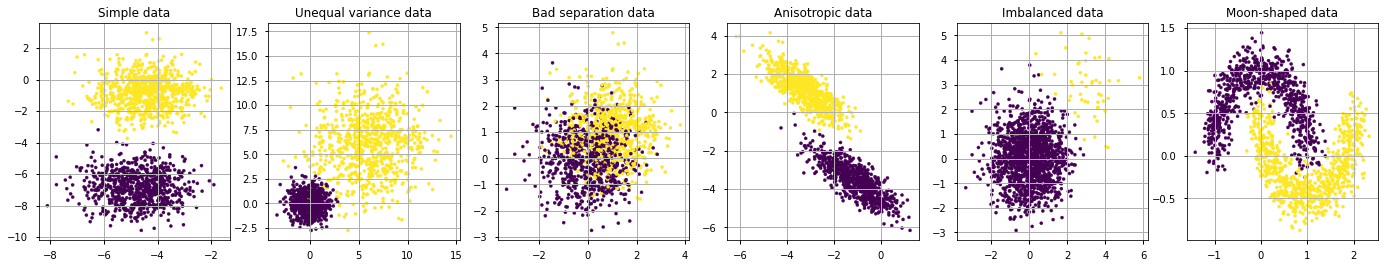

In [2]:
# 1.
data_normal =     make_blobs(n_samples=1500, 
                             cluster_std=[1,1],
                             centers=2, n_features=2, 
                             random_state=rstate)
# 2.
data_diff_var =   make_blobs(n_samples=1500, 
                             cluster_std=[1,3],
                             centers=[[0,0],[6,6]], n_features=2, 
                             random_state=rstate)
# 3.
data_bad_sep =    make_blobs(n_samples=1500, 
                             cluster_std=[1,1],
                             centers=[[0,0],[1,1]], n_features=2, 
                             random_state=rstate)
# 4.
anisotropy_transform = [[0.8, -0.4], [-0.4, 0.8]]
data_anisotropy = (np.dot(data_normal[0], anisotropy_transform), data_normal[1])
# 5.
data_imbalanced = make_blobs(n_samples=[1450, 50], 
                             cluster_std=[1,1],
                             centers=[[0,0],[3,3]], n_features=2, 
                             random_state=rstate)
# 6.
data_moons =      make_moons(n_samples=1500, 
                             noise=.15,
                             random_state=rstate)

data_list = {'Simple data': data_normal, 
             'Unequal variance data': data_diff_var, 
             'Bad separation data': data_bad_sep, 
             'Anisotropic data': data_anisotropy, 
             'Imbalanced data': data_imbalanced, 
             'Moon-shaped data': data_moons}

fig, axs = plt.subplots(1,6, figsize=(24,4))
for i, (dataname, data) in enumerate(data_list.items()):
  X, y = data[0], data[1]
  axs[i].scatter(X[:, 0], X[:, 1], c=y, s=10)
  axs[i].grid(True)
  axs[i].set_title(dataname)
plt.show();

# Train classification methods

First, I will use Dummy Classifier. I also will use default K-means as a example of unsupervised clustering.

Then I will use K Nearest Neighbors, Logistic Regression, Decision Trees (all three are supervised).

I won't tune the models because it's not the main point of this notebook. 

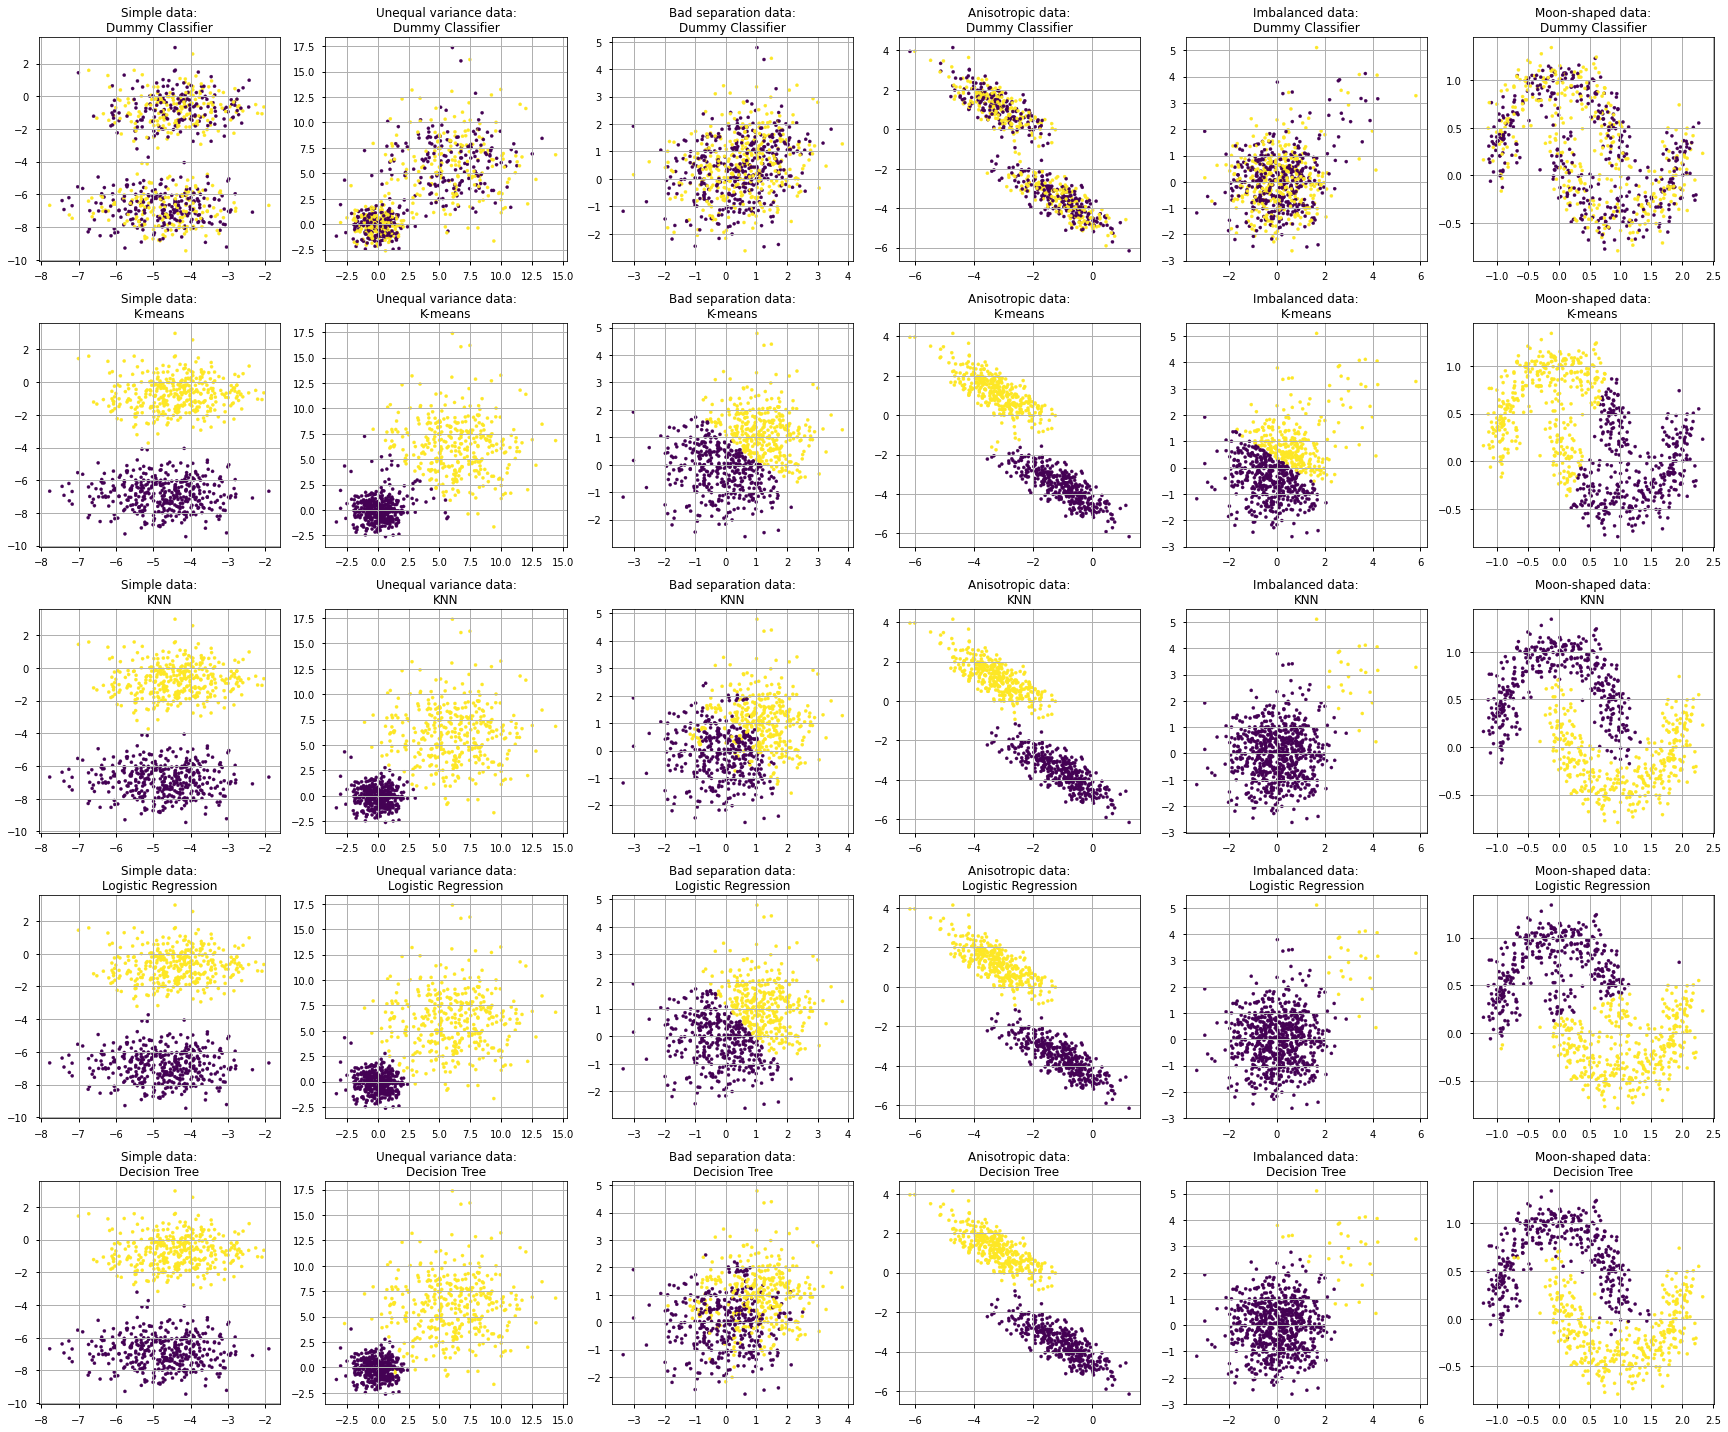

In [3]:
model_list = {'Dummy Classifier': DummyClassifier(strategy='uniform', random_state=rstate),
              'K-means': KMeans(n_clusters=2, random_state=rstate),
              'KNN': KNeighborsClassifier(5),
              'Logistic Regression': LogisticRegression(random_state=rstate),
              'Decision Tree': DecisionTreeClassifier(random_state=rstate)}

# a dict for saving predicted values
results = {}

fig, axs = plt.subplots(len(model_list), len(data_list), figsize=(24,20))
for i, (model_name, model) in enumerate(model_list.items()):
  for j, (dataname, data) in enumerate(data_list.items()):
    X, y = data[0], data[1]
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=.5, random_state=rstate)
    model.fit(xtrain, ytrain)
    yhat = model.predict(xtest)
    results[f'{model_name}: {dataname}'] = (ytest, yhat) # save predictions
    
    axs[i,j].scatter(xtest[:, 0], xtest[:, 1], c=yhat, s=10)
    axs[i,j].grid(True)
    axs[i,j].set_title(f'{dataname}:\n{model_name}')
plt.tight_layout()
plt.show();

# Model Evaluation

## Confusion matrix

Let's plot an example of confusion matrix for KNN used on Bad separation data:

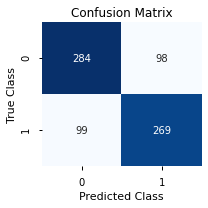

In [4]:
matrix = confusion_matrix(*results['KNN: Bad separation data'])
fig, ax = plt.subplots(1,1, figsize=(3,3))
sns.heatmap(matrix, annot=True, cbar=None, cmap="Blues", fmt='.3g', ax=ax)
ax.set_title("Confusion Matrix")
ax.set_ylabel("True Class"), ax.set_xlabel("Predicted Class")
plt.tight_layout()
plt.show();

For model comparison, usually used metrics are accuracy, precision, recall and f1. Let's calculate all of them for this model and data.

In [5]:
accuracy = accuracy_score(*results['KNN: Bad separation data'])
precision = precision_score(*results['KNN: Bad separation data'])
recall = recall_score(*results['KNN: Bad separation data'])
f1 = f1_score(*results['KNN: Bad separation data'])
print(f'Accuracy: {accuracy:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1: {f1:.2f}')

Accuracy: 0.74
Precision: 0.73
Recall: 0.73
F1: 0.73


Note that above, precision, score and f1 are averaged for all classes. To get separate scores for each class, use `average=None`:

In [6]:
precision = precision_score(*results['KNN: Bad separation data'], average=None)
recall = recall_score(*results['KNN: Bad separation data'], average=None)
f1 = f1_score(*results['KNN: Bad separation data'], average=None)
print(f'Precision: {precision}\nRecall: {recall}\nF1: {f1}')

Precision: [0.74151436 0.73297003]
Recall: [0.7434555  0.73097826]
F1: [0.74248366 0.73197279]


Now we can easily fing the best model (based on selected score) for each dataset:

In [7]:
# Accuracy
for dataname in data_list.keys():
  data_results = [x for x in results.items() if x[0].endswith(dataname)]
  accuracies = []
  for result_name, y_pair in data_results:
    accuracies.append([result_name, accuracy_score(*y_pair)])

  _, best_score = max(accuracies,  key=lambda x: x[1])
  best_models = [x[0] for x in accuracies if x[1]==best_score]
  best_models = ', '.join([x.split(':')[0] for x in best_models])
  print(f'Accuracy for {dataname}:\nBest_score: {best_score}\nBest models: {best_models}\n')

Accuracy for Simple data:
Best_score: 1.0
Best models: K-means, KNN

Accuracy for Unequal variance data:
Best_score: 0.9933333333333333
Best models: KNN

Accuracy for Bad separation data:
Best_score: 0.7786666666666666
Best models: Logistic Regression

Accuracy for Anisotropic data:
Best_score: 1.0
Best models: KNN, Logistic Regression

Accuracy for Imbalanced data:
Best_score: 0.996
Best models: KNN, Logistic Regression

Accuracy for Moon-shaped data:
Best_score: 0.9906666666666667
Best models: KNN



In [8]:
# Recall
for dataname in data_list.keys():
  data_results = [x for x in results.items() if x[0].endswith(dataname)]
  recalls = []
  for result_name, y_pair in data_results:
    recalls.append([result_name, recall_score(*y_pair)])

  _, best_score = max(recalls,  key=lambda x: x[1])
  best_models = [x[0] for x in recalls if x[1]==best_score]
  best_models = ', '.join([x.split(':')[0] for x in best_models])
  print(f'Recall for {dataname}:\nBest_score: {best_score}\nBest models: {best_models}\n')

Recall for Simple data:
Best_score: 1.0
Best models: K-means, KNN

Recall for Unequal variance data:
Best_score: 0.9945652173913043
Best models: Decision Tree

Recall for Bad separation data:
Best_score: 0.7663043478260869
Best models: Logistic Regression

Recall for Anisotropic data:
Best_score: 1.0
Best models: K-means, KNN, Logistic Regression

Recall for Imbalanced data:
Best_score: 1.0
Best models: K-means, Decision Tree

Recall for Moon-shaped data:
Best_score: 0.9945652173913043
Best models: KNN



# ROC curve & AUC

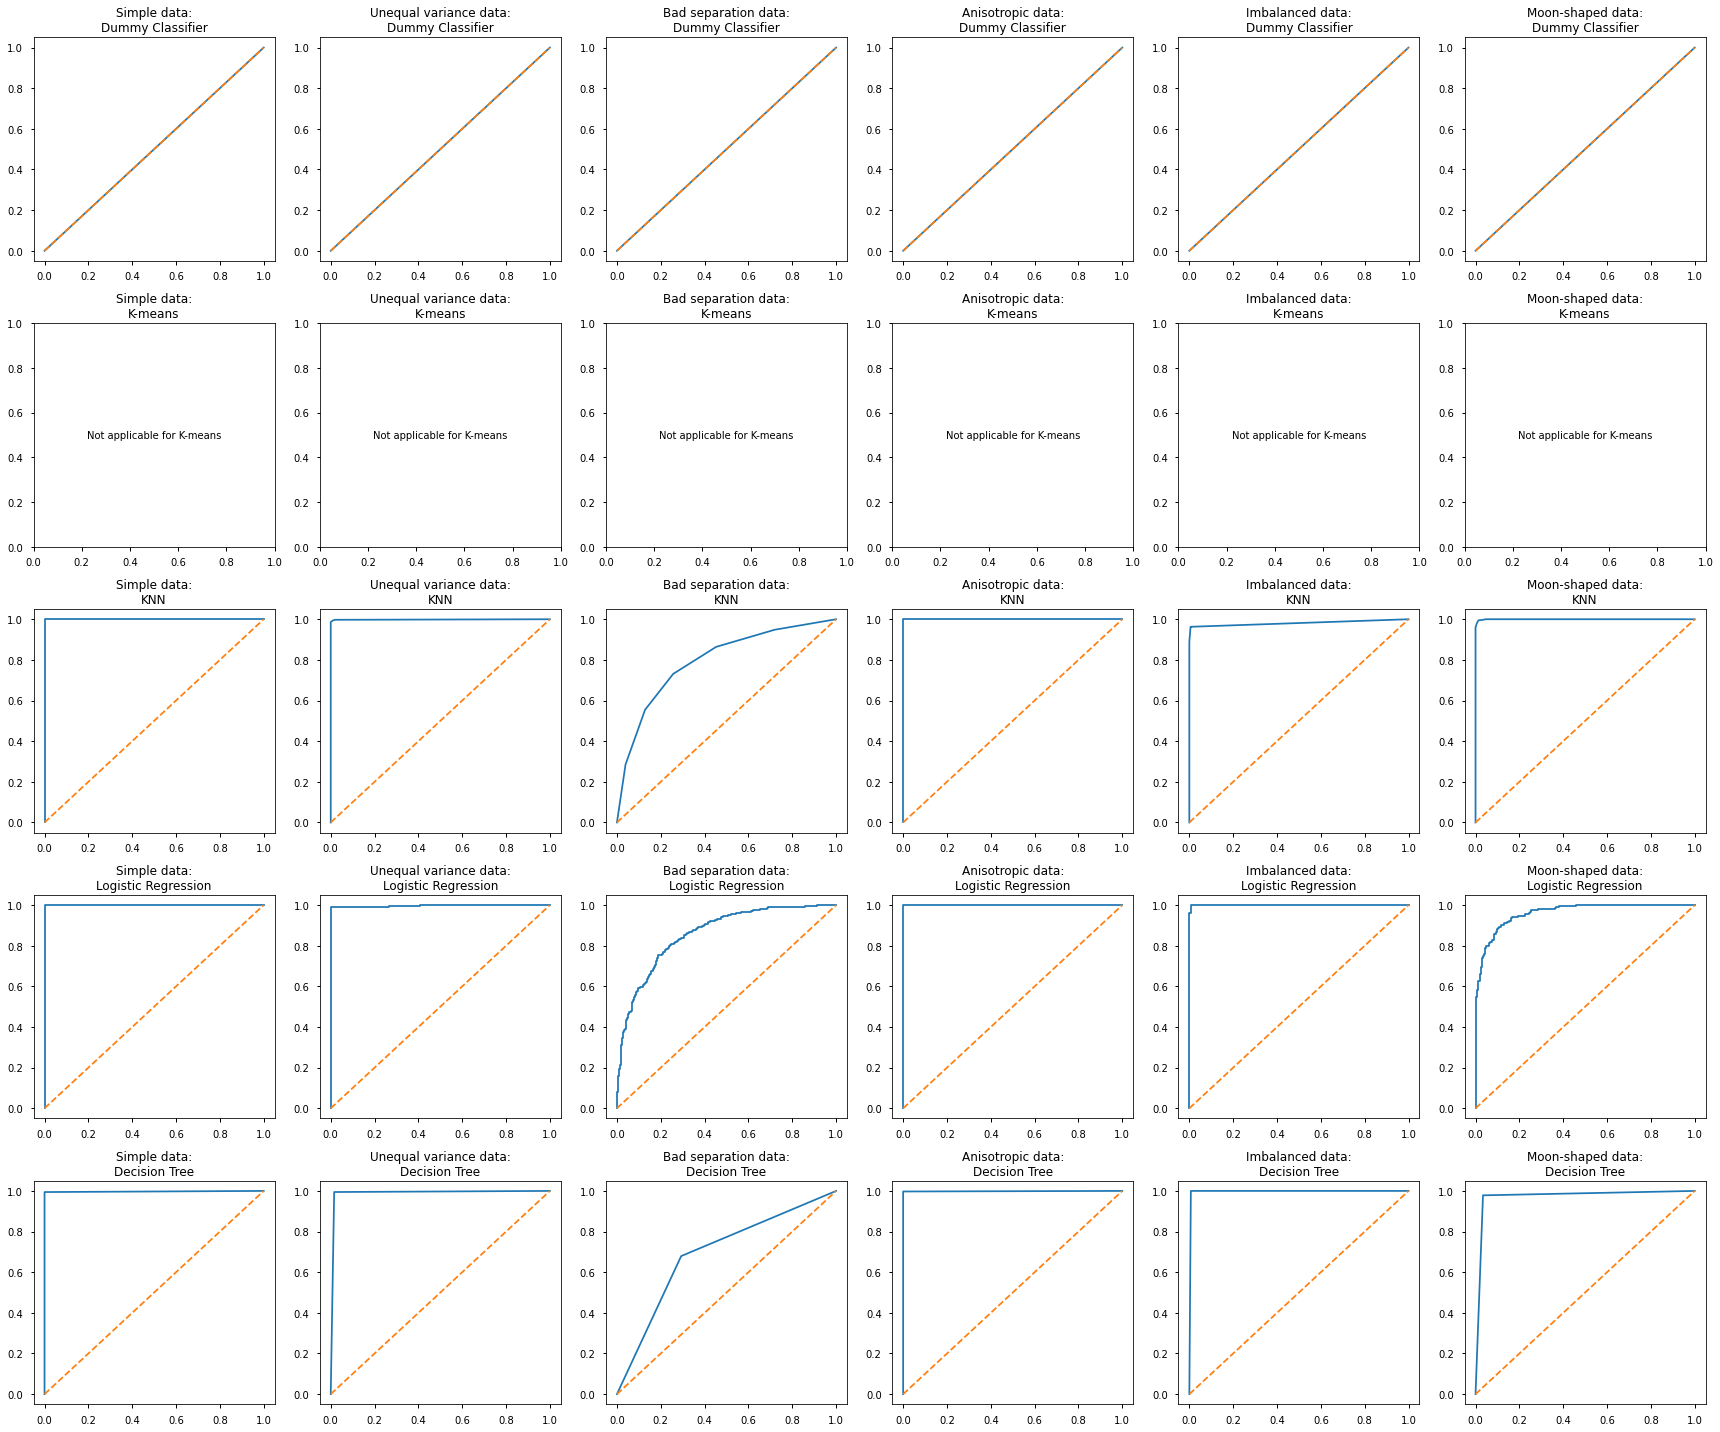

In [9]:
fig, axs = plt.subplots(len(model_list), len(data_list), figsize=(24,20))
for i, (model_name, model) in enumerate(model_list.items()):
  for j, (dataname, data) in enumerate(data_list.items()):
    X, y = data[0], data[1]
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=.5, random_state=rstate)
    model.fit(xtrain, ytrain)
    try:
      probs = model.predict_proba(xtest)[:,1]
      false_positive_rate, true_positive_rate, threshold = roc_curve(ytest, probs)
      axs[i,j].plot(false_positive_rate, true_positive_rate)
      axs[i,j].plot([0,1], ls='--')
    except AttributeError:
      axs[i,j].text(.5, .5, f'Not applicable for {model_name}', ha='center', va='center')
    axs[i,j].set_title(f'{dataname}:\n{model_name}')
plt.tight_layout()
plt.show();